## Simple text classification example with `keras`

1. load, split, and preprocess data 
2. define network structure 
3. train classifier 
4. generate predictions on holdout set 
5. evaluate performance

### 1. Load, split, and preprocess data
<hr>

In [1]:
from keras.datasets import imdb

# restrict vocab size to 10k words (not necessary but speeds up dev)
vocab_n = 10000

(train_X, train_y), (test_X, test_y) = imdb.load_data(num_words=vocab_n)

Using TensorFlow backend.


In [2]:
# check shape of data 
print('train input shape:', train_X.shape)
print('train labels shape:', train_y.shape)

print('test input shape:', test_X.shape)
print('test labels shape:', test_y.shape)

train input shape: (25000,)
train labels shape: (25000,)
test input shape: (25000,)
test labels shape: (25000,)


In [3]:
import numpy as np

# function to create binary DTM from int-encoded docs 
def vectorize_sequences(sequences, dim):
  results = np.zeros((len(sequences), dim))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results


# vectorize the int-encoded documents 
train_X = vectorize_sequences(train_X, dim=vocab_n)
test_X = vectorize_sequences(test_X, dim=vocab_n)

# vectorize the labels too
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')

### 2. Define network structure, compile network
<hr>

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_n, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
optimizer = 'rmsprop'
loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### 3. Train classifier
<hr>

In [6]:
valset_size = 10000

valset_X = train_X[:valset_size]
partial_train_X = train_X[valset_size:]

valset_y = train_y[:valset_size]
partial_train_y = train_y[valset_size:]

In [7]:
# more epochs leads to higher train accuracy 
epochs = 10
batch_size = 512

# note that `history` object has several useful methods 
history = model.fit(partial_train_X, partial_train_y,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(valset_X, valset_y))

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 5s 301us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8684
Epoch 2/10
15000/15000 [==============================] - 4s 272us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8896
Epoch 3/10
15000/15000 [==============================] - 4s 254us/step - loss: 0.2179 - acc: 0.9286 - val_loss: 0.3086 - val_acc: 0.8711
Epoch 4/10
15000/15000 [==============================] - 4s 243us/step - loss: 0.1750 - acc: 0.9438 - val_loss: 0.2840 - val_acc: 0.8834
Epoch 5/10
15000/15000 [==============================] - 4s 258us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2841 - val_acc: 0.8873
Epoch 6/10
15000/15000 [==============================] - 4s 250us/step - loss: 0.1150 - acc: 0.9651 - val_loss: 0.3166 - val_acc: 0.8772
Epoch 7/10
15000/15000 [==============================] - 4s 284us/step - loss: 0.0980 - acc: 0.9707 - val_loss: 0.3127 - 

### 4. Generate predictions 
<hr>

In [8]:
# function to convert a probability into a binary prediction 
def prob_to_binary(prob, threshold=.5, ret_type=bool):
  assert 0 <= prob <= 1
  assert 0 <= threshold <= 1
  return ret_type(prob > threshold)


# generate probabilistic predictions, convert them to binary 
test_probs = model.predict(test_X)
test_preds = [prob_to_binary(prob) for prob in test_probs]

### 5. Evaluate model performance
<hr>

In [9]:
from sklearn.metrics import confusion_matrix

# show confusion matrix 
confusion_matrix(test_y, test_preds)

array([[10942,  1558],
       [ 1821, 10679]])

In [10]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score


eval_metrics = [f1_score, precision_score, recall_score, accuracy_score]

# print various metrics
for func in eval_metrics:
  print(f'{func.__name__} on test: {round(func(test_y, test_preds), 3)}')

f1_score on test: 0.863
precision_score on test: 0.873
recall_score on test: 0.854
accuracy_score on test: 0.865


In [11]:
import matplotlib.pyplot as plt


loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

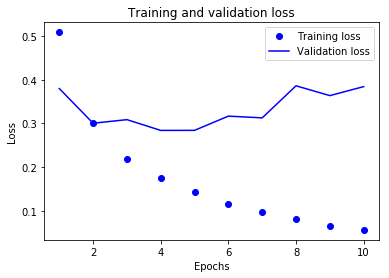

In [12]:
# plot loss curves for train and validation sets during training 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

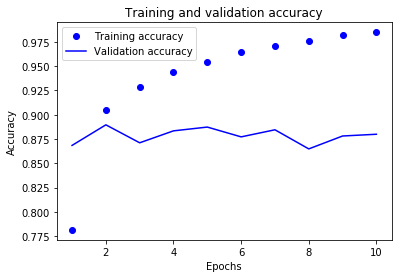

In [13]:
# plot accuracy curves for train and validation sets during training 
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()